In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In this problem we are interested in learning which Titanic passangers survived the crash based off of information we have on them. Prior to building models to do this it is crutial we both understand the data and try to uncover important insights. In a sense, EDA is detective work to help us better understand what is going on.

# Step 1: Let's start by cleaning and reformatting the data
![](https://www.sinequa.com/wp-content/uploads/blog/6-Ways-a-Data-Driven-Approach-Helps-Your-Organization-Succeed-1200.jpg)

In [4]:
print("Training  |  Testing")

for col in train:
    try:
        print(f"{col}: {train[col].isna().sum()}, {test[col].isna().sum()}")
    except:
        print(f"{col}: {train[col].isna().sum()}")

Training  |  Testing
PassengerId: 0, 0
Survived: 0
Pclass: 0, 0
Name: 0, 0
Sex: 0, 0
Age: 177, 86
SibSp: 0, 0
Parch: 0, 0
Ticket: 0, 0
Fare: 0, 1
Cabin: 687, 327
Embarked: 2, 0


We notice that some of the ages and cabin informations of both those in the Training and Testing sets are missing. Assuming that both the passangers' ages and residence locations on the ship should have a large impact on survival we cannot simply drop these points. Embarked and fare is also missing, but given it is only very few samples, it should be sufficent to simply remove those samples.

The cabin variable may be predicatble using the other features and thus we might benifit from using KNN to impute missing values. In addition we can also create another column that tracks if the rows originally had any missing Ages and repace them with the average age.

In [5]:
train['Missing_Age'] = train['Age'].apply(lambda x: 1 if pd.isna(x) else 0)
test['Missing_Age'] = test['Age'].apply(lambda x: 1 if pd.isna(x) else 0)

In [6]:
train['Age']= train['Age'].fillna(train['Age'].mean())
test['Age']= test['Age'].fillna(test['Age'].mean())

We also want to factorize the data

In [7]:
for col in ['Name', 'Ticket', 'Embarked', 'Sex']:
    if train[col].dtype == 'object':
        train[col] = train[col].factorize()[0]
        
for col in ['Name', 'Ticket', 'Embarked', 'Sex']:
    if test[col].dtype == 'object':
        test[col] = test[col].factorize()[0]

In [8]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Missing_Age
0,1,0,3,0,0,22.000000,1,0,0,7.2500,NaN,0,0
1,2,1,1,1,1,38.000000,1,0,1,71.2833,C85,1,0
2,3,1,3,2,1,26.000000,0,0,2,7.9250,NaN,0,0
3,4,1,1,3,1,35.000000,1,0,3,53.1000,C123,0,0
4,5,0,3,4,0,35.000000,0,0,4,8.0500,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,886,0,27.000000,0,0,677,13.0000,NaN,0,0
887,888,1,1,887,1,19.000000,0,0,678,30.0000,B42,0,0
888,889,0,3,888,1,29.699118,1,2,614,23.4500,NaN,0,1
889,890,1,1,889,0,26.000000,0,0,679,30.0000,C148,1,0


In [9]:
Cabin_Known = train[train['Cabin'].isna() == False]
Cabin_Unknown = train[train['Cabin'].isna() == True]

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_range = range(1,21)
scores_list = []

for k in k_range:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    
    knn.fit(Cabin_Known[['PassengerId','Pclass', 'Name', 'Sex', 'Age', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Missing_Age']], Cabin_Known['Cabin'])
    
    y_pred = knn.predict(Cabin_Known[['PassengerId','Pclass', 'Name', 'Sex', 'Age', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Missing_Age']])
    
    scores_list.append(metrics.accuracy_score(Cabin_Known['Cabin'],y_pred))
    
print(scores_list)

[1.0, 0.5441176470588235, 0.39705882352941174, 0.30392156862745096, 0.2549019607843137, 0.23039215686274508, 0.2107843137254902, 0.19607843137254902, 0.17647058823529413, 0.16666666666666666, 0.16176470588235295, 0.15196078431372548, 0.14215686274509803, 0.14215686274509803, 0.14215686274509803, 0.12745098039215685, 0.12254901960784313, 0.12254901960784313, 0.12254901960784313, 0.10294117647058823]


In [11]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(Cabin_Known[['PassengerId','Pclass', 'Name', 'Sex', 'Age', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Missing_Age']],Cabin_Known['Cabin'])

y_pred= knn.predict(Cabin_Unknown[['PassengerId','Pclass', 'Name', 'Sex', 'Age', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Missing_Age']])

In [12]:
Cabin_Unknown['Cabin'] = y_pred

/tmp/ipykernel_20/1847538300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cabin_Unknown['Cabin'] = y_pred


In [13]:
Cabin_Unknown["Cabin"]

0              D56
2              D56
4             C103
5              D56
7               A6
          ...     
884            B42
885            B28
886            B42
888    B51 B53 B55
890            B42
Name: Cabin, Length: 687, dtype: object

In [14]:
train = pd.concat([Cabin_Known, Cabin_Unknown], axis=0)

In [15]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Missing_Age
1,2,1,1,1,1,38.000000,1,0,1,71.2833,C85,1,0
3,4,1,1,3,1,35.000000,1,0,3,53.1000,C123,0,0
6,7,0,1,6,0,54.000000,0,0,6,51.8625,E46,0,0
10,11,1,3,10,1,4.000000,1,1,10,16.7000,G6,0,0
11,12,1,1,11,1,58.000000,0,0,11,26.5500,C103,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,884,0,25.000000,0,0,676,7.0500,B42,0,0
885,886,0,3,885,1,39.000000,0,5,16,29.1250,B28,2,0
886,887,0,2,886,0,27.000000,0,0,677,13.0000,B42,0,0
888,889,0,3,888,1,29.699118,1,2,614,23.4500,B51 B53 B55,0,1


In [16]:
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

In [17]:
Cabin_Known = test[test['Cabin'].isna() == False]
Cabin_Unknown = test[test['Cabin'].isna() == True]

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_range = range(1,21)
scores_list = []

for k in k_range:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    
    knn.fit(Cabin_Known[['PassengerId','Pclass', 'Name', 'Sex', 'Age', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Missing_Age']], Cabin_Known['Cabin'])
    
    y_pred = knn.predict(Cabin_Known[['PassengerId','Pclass', 'Name', 'Sex', 'Age', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Missing_Age']])
    
    scores_list.append(metrics.accuracy_score(Cabin_Known['Cabin'],y_pred))
    
print(scores_list)

[1.0, 0.5054945054945055, 0.3626373626373626, 0.32967032967032966, 0.24175824175824176, 0.2087912087912088, 0.2087912087912088, 0.18681318681318682, 0.16483516483516483, 0.15384615384615385, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.13186813186813187, 0.12087912087912088, 0.10989010989010989, 0.07692307692307693, 0.07692307692307693, 0.08791208791208792]


In [19]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(Cabin_Known[['PassengerId','Pclass', 'Name', 'Sex', 'Age', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Missing_Age']], Cabin_Known['Cabin'])

y_pred= knn.predict(Cabin_Unknown[['PassengerId','Pclass', 'Name', 'Sex', 'Age', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Missing_Age']])

In [20]:
Cabin_Unknown['Cabin'] = y_pred

/tmp/ipykernel_20/1847538300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cabin_Unknown['Cabin'] = y_pred


In [21]:
test = pd.concat([Cabin_Known, Cabin_Unknown], axis=0)

Now the Missing Values are are all resolved!

In [22]:
print("Training  |  Testing")

for col in train:
    try:
        print(f"{col}: {train[col].isna().sum()}, {test[col].isna().sum()}")
    except:
        print(f"{col}: {train[col].isna().sum()}")

Training  |  Testing
PassengerId: 0, 0
Survived: 0
Pclass: 0, 0
Name: 0, 0
Sex: 0, 0
Age: 0, 0
SibSp: 0, 0
Parch: 0, 0
Ticket: 0, 0
Fare: 0, 0
Cabin: 0, 0
Embarked: 0, 0
Missing_Age: 0, 0


In [23]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Missing_Age
1,2,1,1,1,1,38.000000,1,0,1,71.2833,C85,1,0
3,4,1,1,3,1,35.000000,1,0,3,53.1000,C123,0,0
6,7,0,1,6,0,54.000000,0,0,6,51.8625,E46,0,0
10,11,1,3,10,1,4.000000,1,1,10,16.7000,G6,0,0
11,12,1,1,11,1,58.000000,0,0,11,26.5500,C103,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,884,0,25.000000,0,0,676,7.0500,B42,0,0
885,886,0,3,885,1,39.000000,0,5,16,29.1250,B28,2,0
886,887,0,2,886,0,27.000000,0,0,677,13.0000,B42,0,0
888,889,0,3,888,1,29.699118,1,2,614,23.4500,B51 B53 B55,0,1


In [24]:
col = 'Cabin'

train[col] = train[col].factorize()[0]
test[col] = test[col].factorize()[0]

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Name'}>],
       [<Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Ticket'}>,
        <Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Cabin'}>,
        <Axes: title={'center': 'Embarked'}>],
       [<Axes: title={'center': 'Missing_Age'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

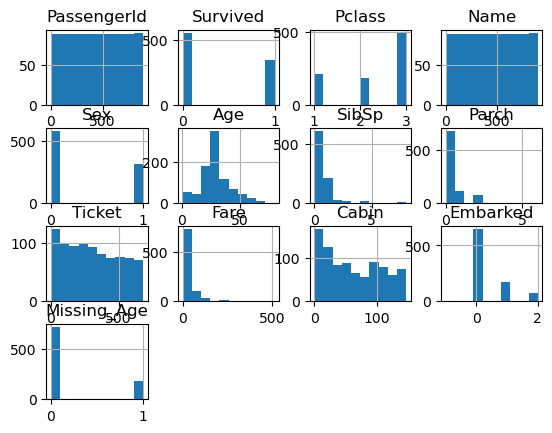

In [25]:
train.hist()

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Name'}>],
       [<Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Ticket'}>,
        <Axes: title={'center': 'Fare'}>],
       [<Axes: title={'center': 'Cabin'}>,
        <Axes: title={'center': 'Embarked'}>,
        <Axes: title={'center': 'Missing_Age'}>]], dtype=object)

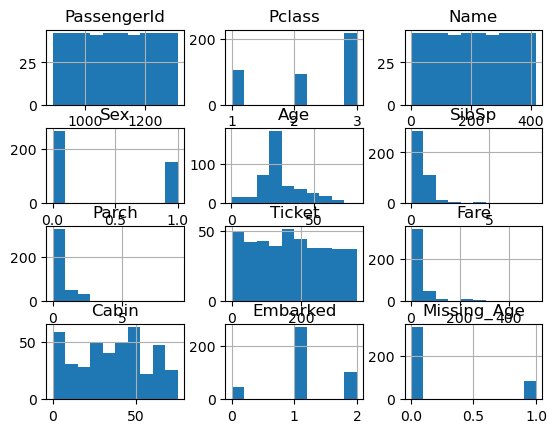

In [26]:
test.hist()

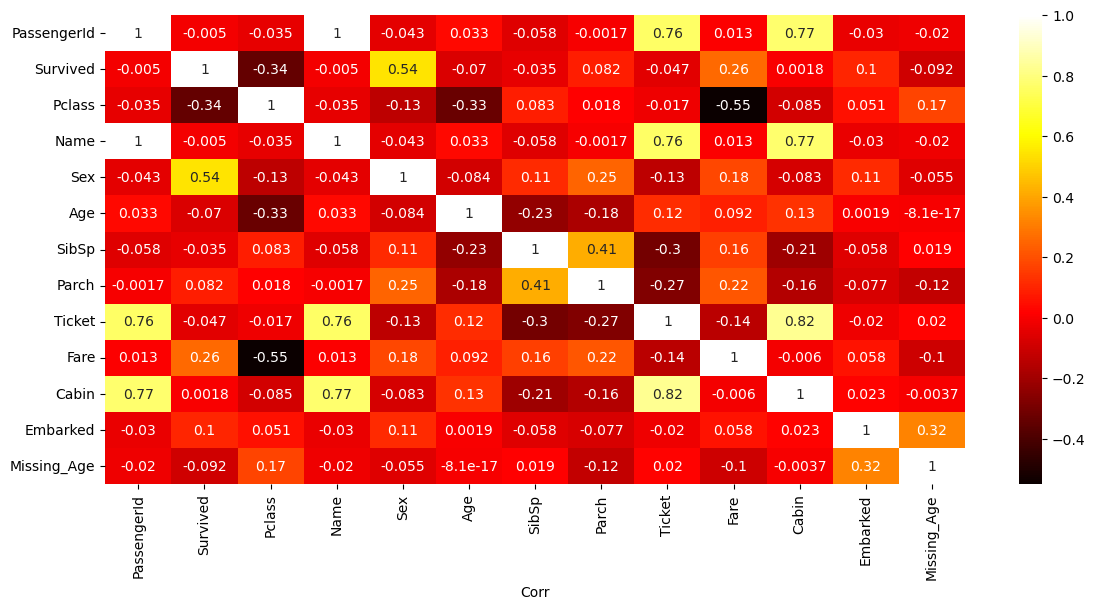

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

figure = plt.figure(figsize=(12, 6))
sns.heatmap(train.corr(), annot=True,cmap=plt.cm.hot)

plt.tight_layout()
plt.xlabel('Corr')
plt.show()

In [28]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train.loc[:,train.columns != 'Survived'], train['Survived'], test_size=0.3)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

metrics.accuracy_score(y_pred, y_val)

0.7723880597014925

In [29]:
# Hyper-Parameter Tuning using Optuna
import optuna
from sklearn.model_selection import train_test_split
from math import sqrt

def objective(trial):
    
    # Split the Data Each time
    X_train, X_valid, y_train, y_valid = train_test_split(train.loc[:,train.columns != 'Survived'], train['Survived'], test_size=0.3, random_state=42)
    
    # Set the Parameters
    max_depth = int(trial.suggest_int('max_depth', 1, 32))
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    min_samples_split = int(trial.suggest_int('min_samples_split', 2, 10))
    min_samples_leaf = int(trial.suggest_int('min_samples_leaf', 1, 10))
    max_feature = trial.suggest_categorical('max_feature', ['auto', 'sqrt', 'log2'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    
    try:
        model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_feature, splitter=splitter)
        model.fit(X_train, y_train)

        return model.score(X_valid, y_valid)
    
    except:
        
        return 0

In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2023-06-19 20:31:30,461] A new study created in memory with name: no-name-e4654b7c-49bd-40ae-b033-c99c149fa43d
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2023-06-19 20:31:30,475] Trial 0 finished with value: 0.7947761194029851 and parameters: {'max_depth': 11, 'criterion': 'log_loss', 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_feature': 'auto', 'splitter': 'best'}. Best is trial 0 with value: 0.7947761194029851.
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2023-06-19 20:31:30,486] Trial 1 finished with value: 0.7723880597014925 and parameters: {'max_depth': 24, 'criterion'

In [31]:
study.best_params, study.best_value

({'max_depth': 11,
  'criterion': 'log_loss',
  'min_samples_split': 7,
  'min_samples_leaf': 5,
  'max_feature': 'auto',
  'splitter': 'best'},
 0.8208955223880597)

In [32]:
Decision_tree_model = tree.DecisionTreeClassifier(criterion='gini', max_depth=11, min_samples_split=9, min_samples_leaf=2, max_features='sqrt', splitter='random')
Decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=11, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=9, splitter='random')

In [33]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_val, y_train, y_val = train_test_split(train.loc[:,train.columns != 'Survived'], train['Survived'], test_size=0.3, random_state=42)

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

metrics.accuracy_score(y_pred, y_val)

0.832089552238806

In [34]:
# Hyper-Parameter Tuning using Optuna

def objective(trial):
    
    # Split the Data Each time
    X_train, X_valid, y_train, y_valid = train_test_split(train.loc[:,train.columns != 'Survived'], train['Survived'], test_size=0.3, random_state=42)
    
    # Set the Parameters
    n_estimator = trial.suggest_int('n_estimators', 2, 400)
    max_depth = int(trial.suggest_int('max_depth', 1, 32))
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    min_samples_split = int(trial.suggest_int('min_samples_split', 2, 10))
    min_samples_leaf = int(trial.suggest_int('min_samples_leaf', 1, 10))
    max_feature = trial.suggest_categorical('max_feature', ['auto', 'sqrt', 'log2'])
    
    try:
        model = RandomForestClassifier(n_estimators=n_estimator, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_feature)
        model.fit(X_train, y_train)

        return model.score(X_valid, y_valid)
    
    except:
        
        return 0

In [35]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2023-06-19 20:31:40,366] A new study created in memory with name: no-name-136ccea9-dd6f-4721-a1a9-fa49101e85d3
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[I 2023-06-19 20:31:41,273] Trial 0 finished with value: 0.835820895522388 and parameters: {'n_estimators': 291, 'max_depth': 19, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_feature': 'auto'}. Best is trial 0 with value: 0.835820895522388.
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is

In [36]:
study.best_params, study.best_value

({'n_estimators': 310,
  'max_depth': 23,
  'criterion': 'entropy',
  'min_samples_split': 8,
  'min_samples_leaf': 1,
  'max_feature': 'sqrt'},
 0.8470149253731343)

In [37]:
Forest_tree_model = RandomForestClassifier(n_estimators=266, criterion='gini', max_depth=8, min_samples_split=3, min_samples_leaf=3, max_features='sqrt')
Forest_tree_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=3,
                       n_estimators=266)

In [38]:
import pandas as pd
from sklearn import preprocessing

x = train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train = pd.DataFrame(x_scaled)

In [39]:
import tensorflow
from tensorflow import keras
from keras import Sequential, layers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [40]:
X_train.shape

(623, 12)

In [41]:
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import keras

X_train, X_valid, y_train, y_valid = train_test_split(train.loc[:,train.columns != 1], train[1], test_size=0.3, random_state=42)

model = Sequential()
model.add(layers.Dense(100, activation='relu', input_shape=(12,)))
model.add(layers.Dense(100, activation='relu', kernel_regularizer='l1'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model.fit(np.array(X_train), np.array(y_train), epochs=200, batch_size=32, validation_data=(np.array(X_valid), np.array(y_valid)), callbacks=[early_stopping])

Epoch 1/200
20/20 [==============================] - 2s 25ms/step - loss: 8.3466 - accuracy: 0.6132 - val_loss: 7.3189 - val_accuracy: 0.6231
Epoch 2/200
20/20 [==============================] - 0s 6ms/step - loss: 6.5216 - accuracy: 0.7464 - val_loss: 5.6747 - val_accuracy: 0.7799
Epoch 3/200
20/20 [==============================] - 0s 7ms/step - loss: 4.9791 - accuracy: 0.8122 - val_loss: 4.2855 - val_accuracy: 0.7985
Epoch 4/200
20/20 [==============================] - 0s 6ms/step - loss: 3.7129 - accuracy: 0.7705 - val_loss: 3.1429 - val_accuracy: 0.8134
Epoch 5/200
20/20 [==============================] - 0s 7ms/step - loss: 2.6621 - accuracy: 0.7994 - val_loss: 2.2264 - val_accuracy: 0.7910
Epoch 6/200
20/20 [==============================] - 0s 7ms/step - loss: 1.8632 - accuracy: 0.7961 - val_loss: 1.5418 - val_accuracy: 0.7948
Epoch 7/200
20/20 [==============================] - 0s 7ms/step - loss: 1.2710 - accuracy: 0.8090 - val_loss: 1.0677 - val_accuracy: 0.8134
Epoch 8/200
